# Предсказание снижения активности покупателей

**Описание проекта** \
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. В особенности тем клиентам, чья активность может снизиться в ближайшее время.\
\
**Цель проекта** \
Разработать модель машинного обучения, которая будет предсказывать вероятность снижения активности покупателей и позволит персонализировать предложения постоянным клиентам.

Задача прогнозирования вероятности снижения активности покупателей в переводе на язык машинного обучения представляет собой задачу классификации, т.к. покупательская активность может снизиться либо остаться прежней.
\
**Описание данных**

Таблица `market_file.csv`, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


Таблица с данными о выручке `market_money.csv`, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.


Таблица с данными о времени (в минутах) `market_time.csv`, которое покупатель провёл на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.


Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца `money.csv`: какую прибыль получает магазин от продаж каждому покупателю.
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Загрузка данных

Для начала импортируем необходимые нам для работы библиотеки.

In [1]:
# Загружаем стандартные библиотеки для работы с данными и визуализации
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
! conda install -y numpy'>=1.22 <=1.26'
import numpy as np
! pip install -U scikit-learn

# Загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Загружаем библиотеку для корреляционного анализа
try:
    import phik
except:
    !pip install phik
    import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Загружаем классы для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Загружаем модели МО
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Загружаем функцию для работы с метриками и признаками
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Загружаем библиотеку SHAP
try:
    import shap
except:
    !pip install shap
    import shap


CondaValueError: invalid package specification: numpy>=1.22 <=1.26



In [2]:
# Отключим предупреждения
import warnings
warnings.filterwarnings("ignore")

Осуществим загрузку с сохранением в соответствующие переменные:
- данных о поведении покупателей на сайте из таблицы `market_file.csv`, 
- данных о выручке, которую магазин получает от покупателей из таблицы `market_money.csv`,
- данных о времени, которое покупатель провел на сайте - `market_time.csv`,
- данных о среднемесячной прибыли за последние 3 месяца - `money`.

In [3]:
# Загрузка данных
market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

Для проверки корректности прочтения данных выгрузим первые 5 строк каждого датасета.

In [4]:
# Зададим просмотр максимального количества колонок
pd.set_option('display.max_columns', None)
# Выгрузим первые 5 строк каждого датафрейма
print(market_file.head())
print('-'*100)
print(market_money.head())
print('-'*100)
print(market_time.head())
print('-'*100)
print(money.head())

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

Выведем общую информацию о каждом датафрейме.

In [5]:
market_file.info()
print('-'*100)
market_money.info()
print('-'*100)
market_time.info()
print('-'*100)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Проведем предварительный анализ данных с помощью информации выше. Судя по общим данных о датасетах и первых пяти строкам, можно сказать следующее:
- `market_file`:
   - таблица содержит 13 колонок и 1300 строк;
   - в столбцах таблицы отсутствуют явные пропуски;
   - типы данных столбцов соответствуют их смысловому содержанию;
   - в колонках с категориальными данными есть потенциальные ошибки в написании категорий (например, 'стандартт' в колонке 'Тип сервиса');
- `market_money`:
   - таблица содержит 3 колонки и 3900 строк;
   - в столбцах таблицы отсутствуют явные пропуски;
   - типы данных столбцов соответствуют их смысловому содержанию;
- `market_time`:
   - таблица содержит 3 колонки и 2600 строк;
   - в столбцах таблицы отсутствуют явные пропуски;
   - типы данных столбцов соответствуют их смысловому содержанию;
   - в колонке 'Период', как видно из 5 первых строк таблицы, есть ошибки в написании категории периода ('предыдцщий_месяц');
- `money`:
   - таблица содержит 2 колонки и 1300 строк;
   - в столбцах таблицы отсутствуют явные пропуски;
   - типы данных столбцов соответствуют их смысловому содержанию.

## Предобработка данных

Для удобства дальнейшей работы заменим пробелы в названии столбцов на нижние подчеркивания. Названия столбцов оставим кирилицей.

In [6]:
market_file.columns = ['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит']

market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Как мы могли видеть из таблиц с общей информацией о датасетах, явных пропусков в колонках нет. Проверим таблицы на наличие дубликатов. Для начала посмотрим, есть ли в датафреймах строки-полные дубликаты.

In [7]:
# Проверка наличия полных дубликатов
print('Кол-во дубликатов в данных о поведении покупателей на сайте и взаимодействии с ними:', market_file.duplicated().sum())
print('Кол-во дубликатов в данных о деньгах, которые покупатели потратили на сайте (выручке):', market_money.duplicated().sum())
print('Кол-во дубликатов в данных о времени, проведенном покупателем на сайте:', market_time.duplicated().sum())
print('Кол-во дубликатов в данных о среднемесячной прибыли от одного покупателя:', money.duplicated().sum())

Кол-во дубликатов в данных о поведении покупателей на сайте и взаимодействии с ними: 0
Кол-во дубликатов в данных о деньгах, которые покупатели потратили на сайте (выручке): 0
Кол-во дубликатов в данных о времени, проведенном покупателем на сайте: 0
Кол-во дубликатов в данных о среднемесячной прибыли от одного покупателя: 0


Строк-явных дубликатов в данных не обнаружено. Проверим категориальные столбцы на наличие различных вариантов написания одной и той же категории.

In [8]:
# Зададим функцию для быстрого вывода уникальных значений категориальных столбцов
def cat_column_check(data):
    for column in data.select_dtypes(include='object').columns:
        print(column)
        print(data[column].sort_values().unique())
        print('-'*40)
    
cat_column_check(market_file)

Покупательская_активность
['Прежний уровень' 'Снизилась']
----------------------------------------
Тип_сервиса
['премиум' 'стандарт' 'стандартт']
----------------------------------------
Разрешить_сообщать
['да' 'нет']
----------------------------------------
Популярная_категория
['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']
----------------------------------------


In [9]:
market_file['Тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: Тип_сервиса, dtype: int64

In [10]:
cat_column_check(market_time)

Период
['предыдцщий_месяц' 'текущий_месяц']
----------------------------------------


In [11]:
cat_column_check(market_money)

Период
['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц']
----------------------------------------


In [12]:
market_money.pivot_table(index='Период', values='Выручка', aggfunc=['count','sum'])

,count,sum
,Выручка,Выручка
Период,,
предыдущий_месяц,1300,6417996.5
препредыдущий_месяц,1300,6272769.0
текущий_месяц,1300,6909449.1


Как мы заметили на этапе загрузки данных, в таблице `market_file` действительно содержится ошибка в написании типа сервиса, из-за которой возникло два варианта написания типа "стандарт". Устраним это и оставим вариант "стандарт".\
В таблице market_time исправим ошибку в колонке `Период`, заменив "предыдцщий_месяц" на "предыдущий_месяц".
В таблице market_money встретилось встретилось значение препредыдущий месяц, которого не было в описании данных таблицы. Судя по сделанной сводной таблице выше, это действительно могут быть данные за пред-предыдущий месяц: количество строк и объемы выручки совпадают с данными за текущий и предыдущий месяц. 

In [13]:
# Исправление ошибок
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
# Проверка
cat_column_check(market_file) 
cat_column_check(market_time)

Покупательская_активность
['Прежний уровень' 'Снизилась']
----------------------------------------
Тип_сервиса
['премиум' 'стандарт']
----------------------------------------
Разрешить_сообщать
['да' 'нет']
----------------------------------------
Популярная_категория
['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']
----------------------------------------
Период
['предыдущий_месяц' 'текущий_месяц']
----------------------------------------


## Исследовательский анализ данных

### Анализ таблицы market_file
Проведем анализ категориальных столбцов таблицы `market_file`.

In [14]:
def pie_plot(data, col_list):
    
    fig, axes = plt.subplots(1, col_list.shape[0], figsize=(25,20))

    i=0
    for column in col_list:
        data[column].value_counts().plot(kind = 'pie',
                                            autopct = '%1.0f%%',
                                            title = column,
                                            cmap='tab20c',
                                            ylabel=None,
                                            ax = axes[i])
    
    
        axes[i].yaxis.set_visible(False)
        i = i+1

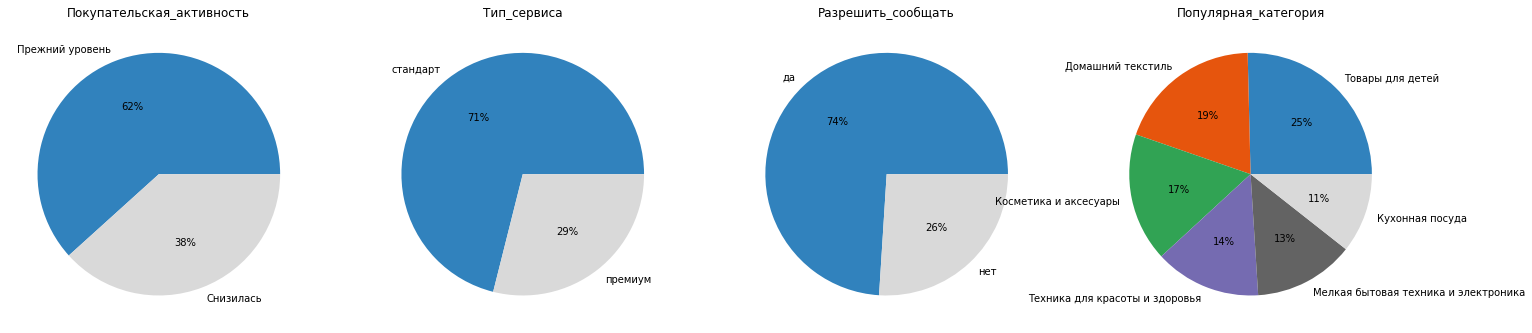

In [15]:
pie_plot(market_file, market_file.select_dtypes(include='object').columns)

Из диаграмм выше можно сказать следующее:
- покупательская активность 62% клиентов находится на прежнем уровне, у оставшихся 38% она снизилась. Таким образом мы можем видеть дисбаланс классов целевого признака. Это необходимо учесть при обучении моделей;
- 71% клиентов получает сервис уровня "стандарт", 29% - сервис уровня "премиум";
- большая часть клиентов (74%) позволяет направлять им дополнительную информацию о товарах и акциях. Оставшиеся 26% - не дают на это согласия. Удержать таких клиентов очередной акцией не получится;
- самом популярной категорией товаров среди клиентов за последние 6 месяцев является категория "Товары для детей" (25%), второй "Домашний текстиль" (19%), далее следуют "Косметика и аксессуары" (17%), "Техника для карсоты и здоровья" (14%), "Мелкая бытовая техника и электроника" (13%) и "Кухонная посуда" (11%).

Перейдем к анализу количественных показателей. Для оптимизации анализа зададим функцию `num_col_analysis`.

In [16]:
def num_col_analysis(data, column, label, lim=None, bins=25, boxplot=True, stats=True):
    # Задаем график и сетку
    fig = plt.figure(figsize=(12,9))
    fig.suptitle(column)
    gs = GridSpec(2, 1, height_ratios=[3.5, 1])
    
    # Добавляем гистограмму
    ax1 = fig.add_subplot(gs[0])
    ax1.hist(data[column], bins=bins)
    ax1.set_title('Гистограмма распределения показателя',y=1)
    #ax1.set_xlabel(label)
    ax1.set_ylabel('Кол-во покупателей')
    ax1.set_xlim(lim)
    
    # Добавляем диаграмму размаха
    if boxplot==True:
        ax2 = fig.add_subplot(gs[1])
        ax2.boxplot(data[column],vert=False)
        ax2.set_title('Диаграмма размаха', y=1)
        ax2.set_xlabel(label)
        ax1.set_xlim(lim)
    else:
        pass

    plt.show();
    
    # Вывод описательной статистики о показателе
    if stats==True:
        temp = data.describe().T
        print('Описательная статистика показателя')
        return temp.loc[temp.index==column]
    else: 
        pass

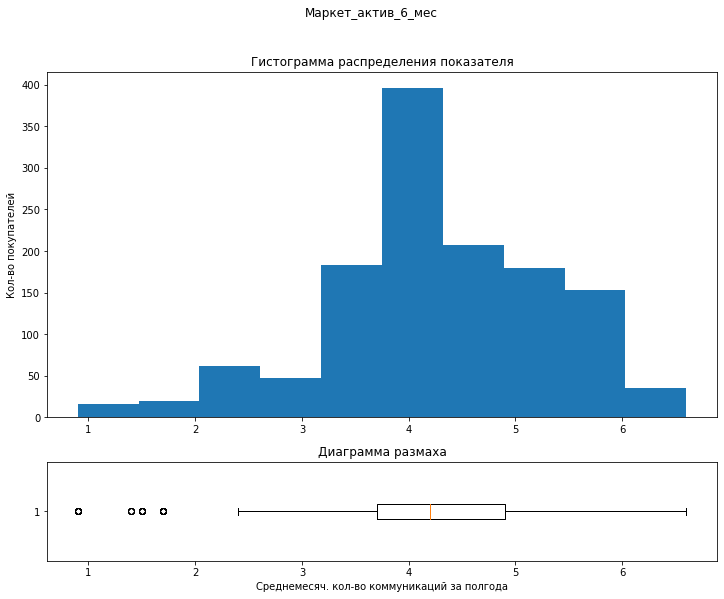

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.7,4.2,4.9,6.6


In [17]:
num_col_analysis(market_file, 'Маркет_актив_6_мес', 'Среднемесяч. кол-во коммуникаций за полгода', bins=10)

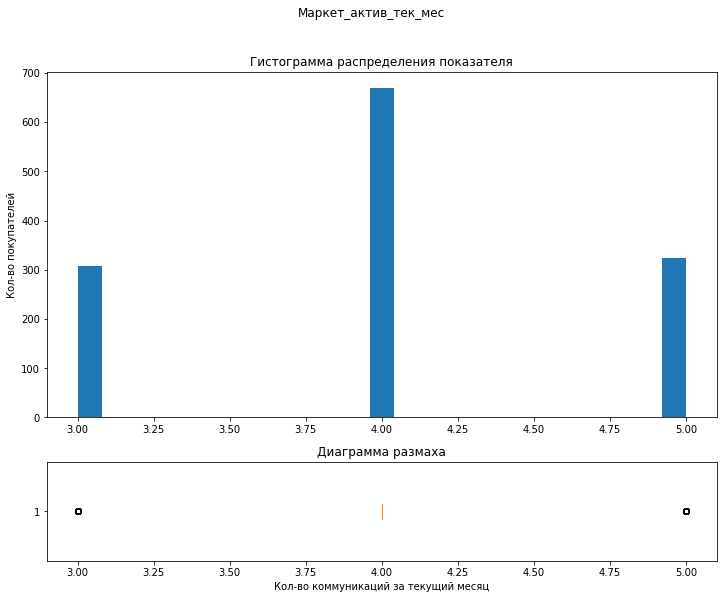

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.0,4.0,4.0,5.0


In [18]:
num_col_analysis(market_file, 'Маркет_актив_тек_мес', 'Кол-во коммуникаций за текущий месяц')

Если говорить о количестве маркетинговых коммуникаций за текуший месяц, то можно отметить, что встречается всего три значения числа коммуникаций, которые приходились на клиентов в текущем месяце: 3, 4 и 5. Самое большое число клиентов (669) получили за текущий месяц 4 коммуникации и практически равное число клиентов (около 300) получили по 3 и 5 коммуникаций. 

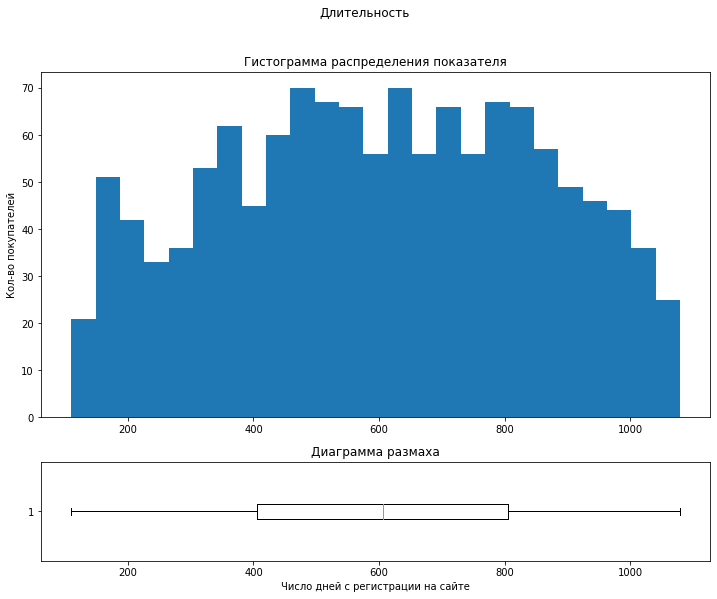

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Длительность,1300.0,601.898462,249.856289,110.0,405.5,606.0,806.0,1079.0


In [19]:
num_col_analysis(market_file, 'Длительность', 'Число дней с регистрации на сайте')

Распределение длительности регистрации клиентов на сайте скорее напоминает равномерное. Среднее и медианное значения очень близки (606 и 601 клиент соответственно). Минимальное количество дней с момента регистрации на сайте составляет 110 дней, максимальное - 1079 дней. Диаграмма размаха не показала наличия каких-либо аномальных значений.

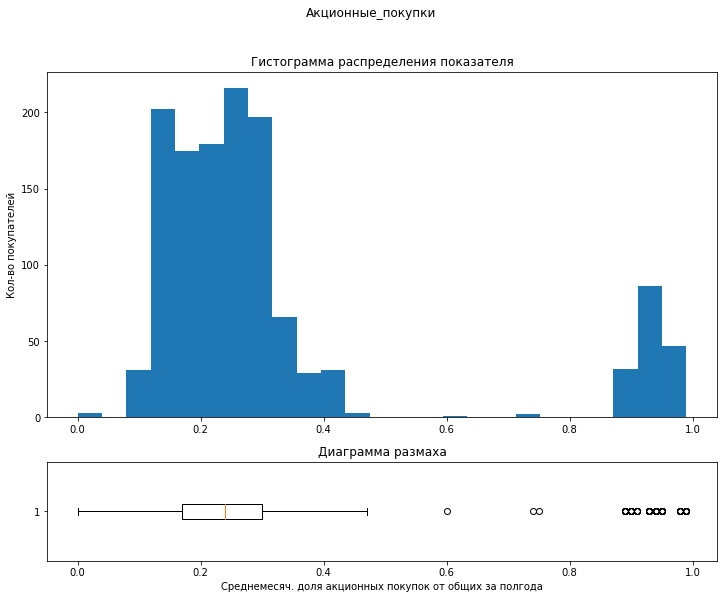

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99


In [20]:
num_col_analysis(market_file, 'Акционные_покупки', 'Среднемесяч. доля акционных покупок от общих за полгода')

Среднемесячная доля акционных покупок от общего числа покупок имеет очень интересное распределение. На гистограмме видно два явных кластера значений: от 0 до 0,5 и выше 0,8. Очевидно, что такая ситуация отражает различное поведение клиентов, где первая группа клиентов до 50% своих покупок формирует в том числе из акционных товаров, а вторая группа свои покупки формирует почти исключительно за счет акционных предложений. Отметим, что первой группы пользователей значительно больше (чуть больше 75% всех пользователей). Вторая группа незначительна, и такие значения доли акционных покупок являются скорее нетипными для клиентов данного интернет-магазина. Встречается также практически околонулевое количество клиентов, которые вовсе не пользуются акциями, а также те, кто 60%-70% своих покупок осуществляют по акциям.\
Вторую группу пользователей мы не будем считать выбросами, так как такое поведение может вполне встречаться у покупателей.

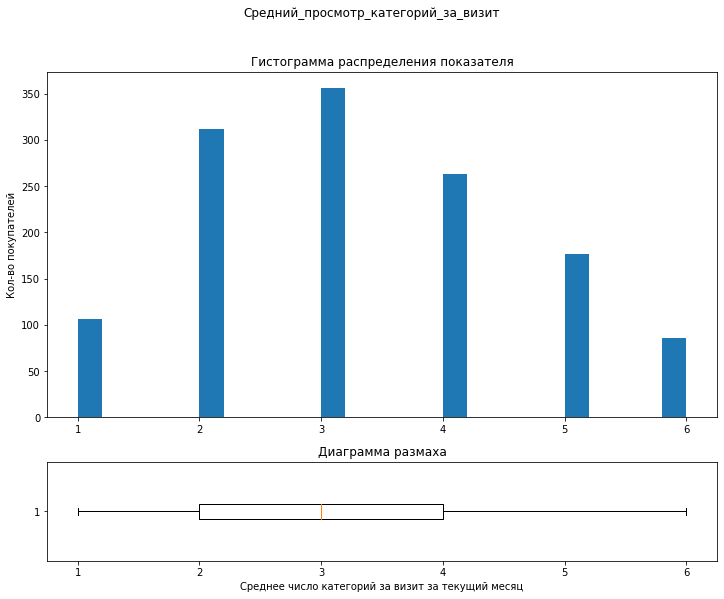

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Средний_просмотр_категорий_за_визит,1300.0,3.27,1.35535,1.0,2.0,3.0,4.0,6.0


In [21]:
num_col_analysis(market_file, 'Средний_просмотр_категорий_за_визит', 'Среднее число категорий за визит за текущий месяц')

Среднее число просматриваемых категорий за визит распределено достаточно ожидаемо, без каких-либо аномалий. Большинство клиентов (50%) просматривают от 2 до 4 категорий товаров за визит. Около 100 клиентов просматривают только одну категорию, чуть больше 150 - 5 категорий, чуть меньше 100 клиентов - 6 категорий.

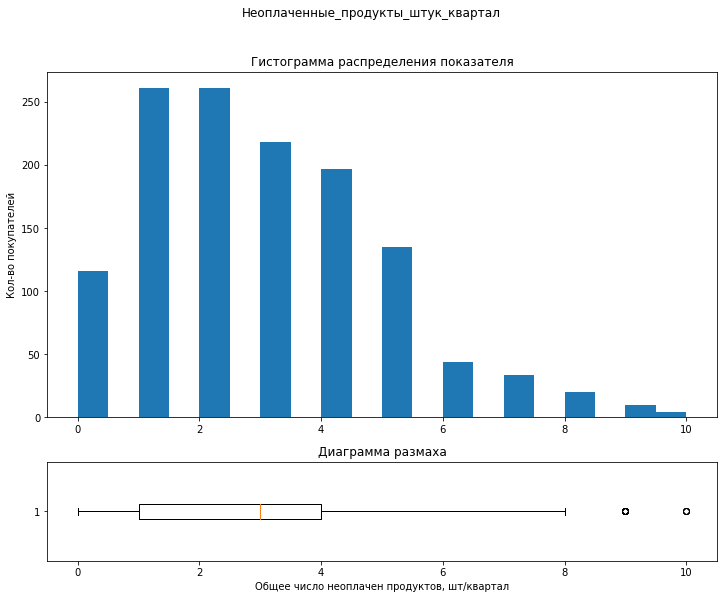

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Неоплаченные_продукты_штук_квартал,1300.0,2.84,1.971451,0.0,1.0,3.0,4.0,10.0


In [22]:
num_col_analysis(market_file, 'Неоплаченные_продукты_штук_квартал',
                 'Общее число неоплачен продуктов, шт/квартал', bins=20)

In [23]:
market_file.query('Неоплаченные_продукты_штук_квартал>=9')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
72,215420,Снизилась,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,Снизилась,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5
117,215465,Снизилась,стандарт,да,3.5,5,449,0.28,Домашний текстиль,1,9,2,2
118,215466,Снизилась,премиум,нет,2.4,5,523,0.30,Техника для красоты и здоровья,1,10,1,4
176,215524,Снизилась,стандарт,да,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2
186,215534,Снизилась,премиум,нет,4.0,4,419,0.93,Товары для детей,1,9,3,3
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
216,215564,Снизилась,стандарт,нет,3.9,3,618,0.24,Техника для красоты и здоровья,2,10,3,5
246,215594,Снизилась,стандарт,да,4.2,4,627,0.90,Товары для детей,6,9,5,8
251,215599,Снизилась,стандарт,да,3.4,4,716,0.28,Домашний текстиль,2,9,4,6


Большая часть клиентов имеет общее число неоплаченных продуктов за квартал от 0 до 5 (чуть более 75%), при этом значения до 8 неоплаченных продуктов являются досточно типичными для клиентов данного интернет-магазина. Нетипичными являются неоплаченные продукты в количестве 9 и 10 штук за квартал. Таких клиентов немного (14) и у всех из них снизилась покупательская активность. С точки зрения предсказания снижения покупательской активности такие клиенты могут быть особо интересными и полезными для обучения модели. 

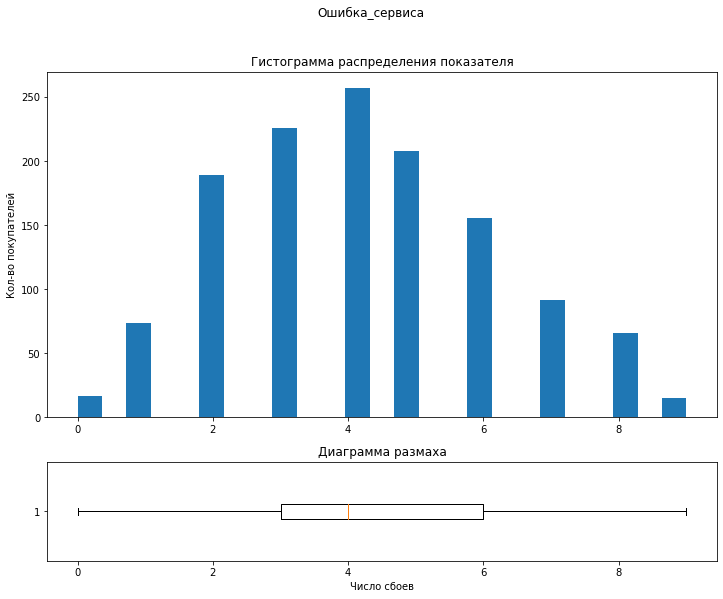

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.0,4.0,6.0,9.0


In [24]:
num_col_analysis(market_file, 'Ошибка_сервиса', 'Число сбоев')

По графику распределения количества ошибок сервиса, которые коснулись клиента во время посещения сайта, можно сказать что большинство клиентов столкнулось хотя бы с одной ошибкой, нестолкнувшихся ни с одной - очень мало. Распределение числа ошибок по конфигурации напоминает нормальное. Каких-то нетипичных значений не наблюдается. 

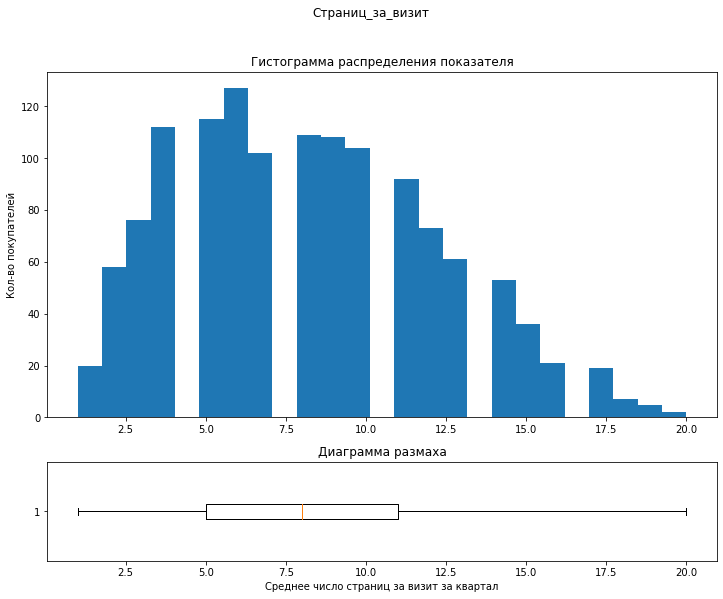

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.0,8.0,11.0,20.0


In [25]:
num_col_analysis(market_file, 'Страниц_за_визит', 'Среднее число страниц за визит за квартал')

Минимальное среднее количество страниц за один визит за квартал составило 1, максимальное - 20.  Большая часть клиентов просматривает от 2 до 15 страниц за визит. Каких-либо нетипичных значений не наблюдается.

### Анализ таблицы market_money

На этапе предобработки данных мы уже видели, что единственный категориальный признак таблицы market_money `Период` имеет три значения с одинаковым числом строк (1300): 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'. 1300 - это число клиентов из таблицы `market_file`. Т.е. таблица market_money содержит данные по каждому из 1300 клиентов за последние три месяца.\
Проанализируем количественный признак `Выручка` таблицы.

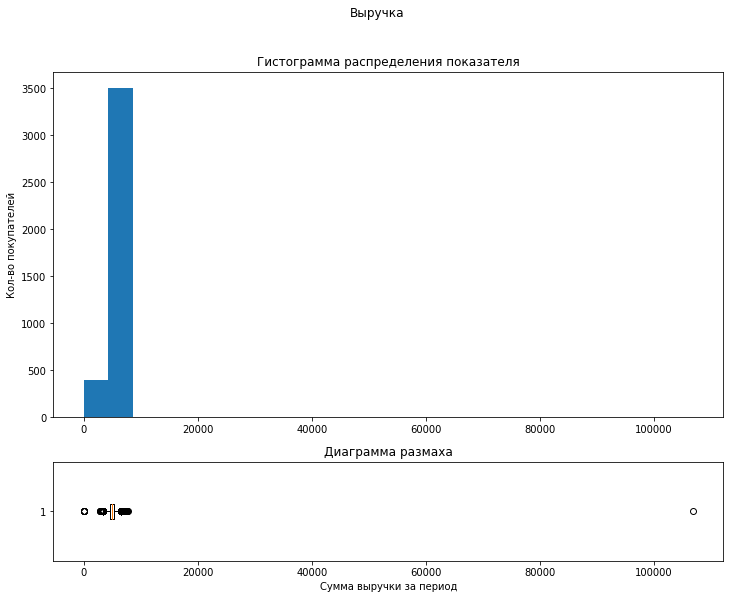

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


In [26]:
num_col_analysis(market_money, 'Выручка', 'Сумма выручки за период')

Диаграмма распределения выручки за три последних месяца выглядит достаточно странно. Причиной этого является нетипично высокое значение выручки, равное 106 862,2. Выгрузим строки, содержащие такое большое значение.

In [27]:
market_money.query('Выручка>20000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [28]:
market_money.query('id==215380')

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [29]:
market_file.query('id==215380')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Оказалось, что нетипично высокое для данного интернет-магазина значение выручки попалось лишь у одного клиента. При этом анализ его покупательского поведения показал, что для него самого такое значение является не очень привычным, по крайней мере за последние три месяца. В два предыдущие месяца он приобратал товаров на примерно одинаковую сумму (в препредыдущем месяце она составила 5051, в предыдущем месяце - 6077), а в текущем - на сумму в разы больше. При этом у покупателя значение целевого признака "Покупательская_активность" установлено как "Снизилось". Если эта оценка проставлена на основе данных за предыдущие периоды, которых у нас нет, мы не можем это проверить. Предлагается уточнить у заказчика детали об этом покупателе и пока исключить его из дальнейшего анализа.\
Посмотрим, как будет выглядеть распределение выручки, если не брать в рассмотрение этого клиента.

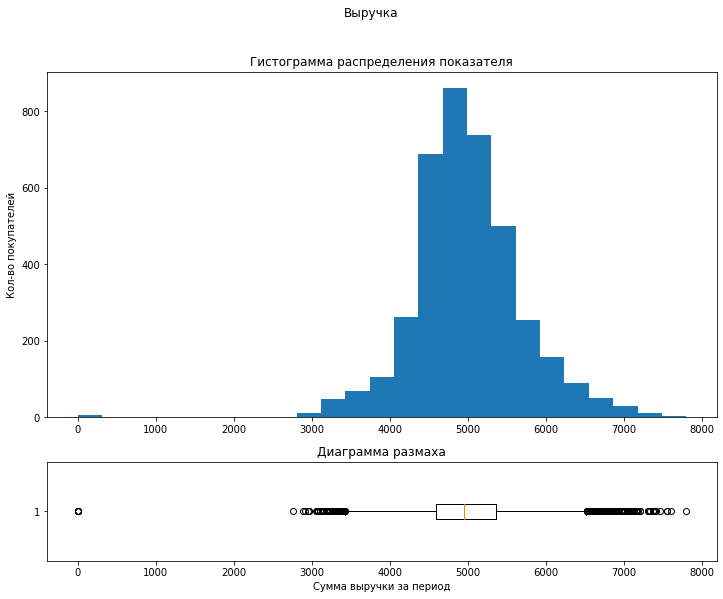

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,3897.0,4999.28776,706.970089,0.0,4590.0,4956.0,5363.0,7799.4


In [30]:
num_col_analysis(market_money.query('id!=215380'), 'Выручка', 'Сумма выручки за период')

Гистограмма распределения выручки сразу стала лучше. Само распределение напоминает нормальное. На гистограмме мы видим выброс в районе нуля. Также мы видим множество потенциально нетипичных значений на диаграмме разброса за левым и правым усами.
Большая часть покупателей генирирует выручку от 4000 до примерно 6000 за период (в случае графика выше - за квартал). 
Выгрузим строки, которые образуют выброс по выручке в районе нуля.

In [31]:
market_money.query('Выручка<2000')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [32]:
market_money.query('Выручка==0')['id'].unique()

array([215348, 215357, 215359])

Выброс в районе нуля образуют три клиента, у которых, судя по выгрузке выше, покупательская активность наблюдась только в текущем месяце. Именно этих пользователей нам необходимо будет удалить из рассмотрения, так как они не соответствуют условию наличия покупательской активности не менее трех месяцев. 

In [33]:
# Формируем список клиентов к удалению: клиент с нетипично высокой выручкой и с покупательской активностью менее 3 месяцев
clients_to_exclude= market_money.query('Выручка==0 | Выручка>20000')['id'].unique()

# Создаем новую таблицу market_money_new без этих клиентов
market_money_new = market_money.query('id not in @clients_to_exclude')

# Проверяем число строк после исключения клиентов
print('Число строк после удаления клиентов с выбросами и низкой покупательской активностью',\
     market_money_new.shape[0])

Число строк после удаления клиентов с выбросами и низкой покупательской активностью 3888


Теперь посмотрим на распределение выручки без данных о клиентах с низкой активностью и выбросов. Также посмотрим, каким образом выглядит распределение за каждый рассматриваемый месяц.

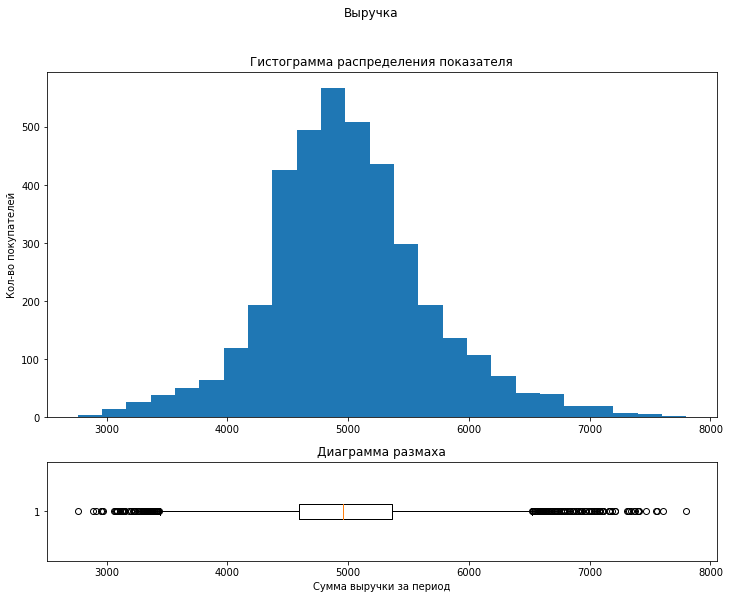

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,3888.0,5007.255658,679.193461,2758.7,4591.95,4959.0,5363.0,7799.4


In [34]:
num_col_analysis(market_money_new, 'Выручка', 'Сумма выручки за период')

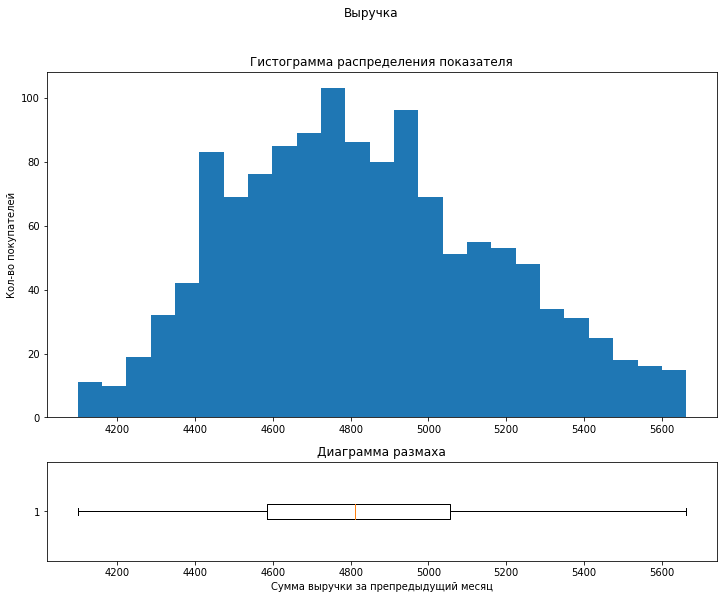

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,1296.0,4836.20216,333.514091,4098.0,4584.5,4810.5,5056.0,5663.0


In [35]:
num_col_analysis(market_money_new.query('Период=="препредыдущий_месяц"'),
                 'Выручка', 'Сумма выручки за препредыдущий месяц')

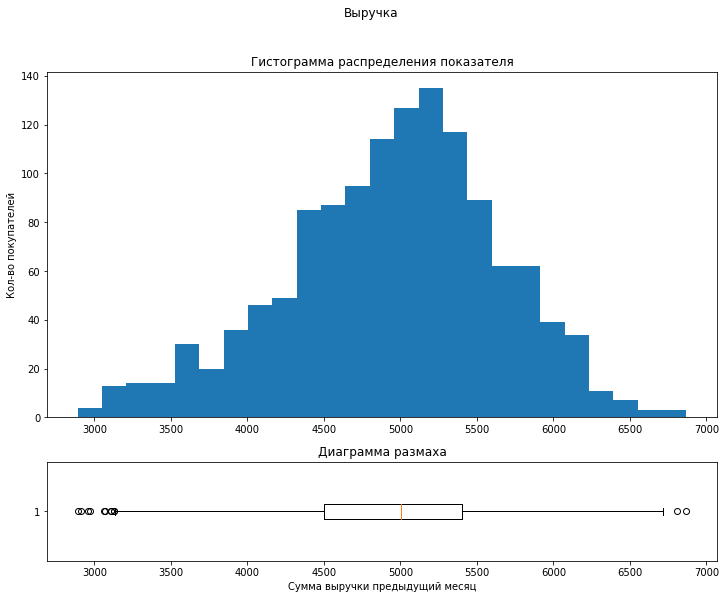

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,1296.0,4947.46875,700.797239,2890.0,4498.125,5005.5,5405.625,6869.5


In [36]:
num_col_analysis(market_money_new.query('Период=="предыдущий_месяц"'), 
                 'Выручка', 'Сумма выручки предыдущий месяц')

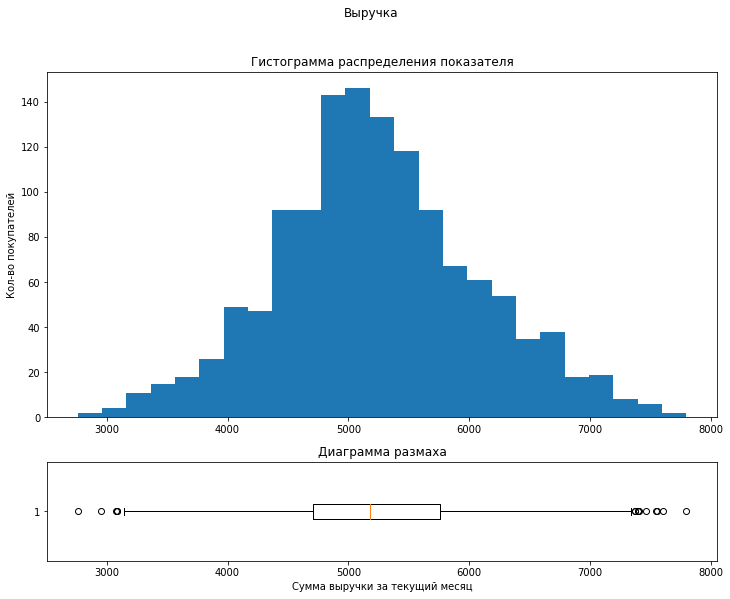

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Выручка,1296.0,5238.096065,834.318717,2758.7,4706.05,5179.95,5759.275,7799.4


In [37]:
num_col_analysis(market_money_new.query('Период=="текущий_месяц"'), 
                 'Выручка', 'Сумма выручки за текущий месяц')

Распределение выручки за весь квартал  выглядит уже гораздо лучше. Также мы видим, что распределение выручки немного отличается от месяца к месяцу, но это вполне нормально. Продажи не могут каждый месяц быть совершенно одинаковыми.

### Анализ таблицы market_time
Проанализируем качественные и количественные показатели таблицы.

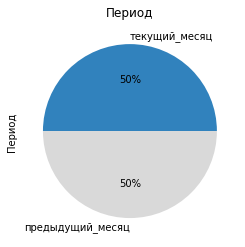

In [38]:
# Построим график для категориального столбца
market_time['Период'].value_counts().plot(kind = 'pie',
                                            autopct = '%1.0f%%',
                                            title = 'Период',
                                            cmap='tab20c',
                                            ylabel=None);

Мы видим, что судя по значениям в столбце `Период`, в таблице `market_time` равное количество значений по текущему и предыдущему периоду.\
Изучим распределение и характеристики минут, проведенных каждым пользователем за период. Сначала рассмотрим распределение без удаления данных о клиентах, с покупательской активностью менее 3 месяцев и с нетипично высокой выручкой.

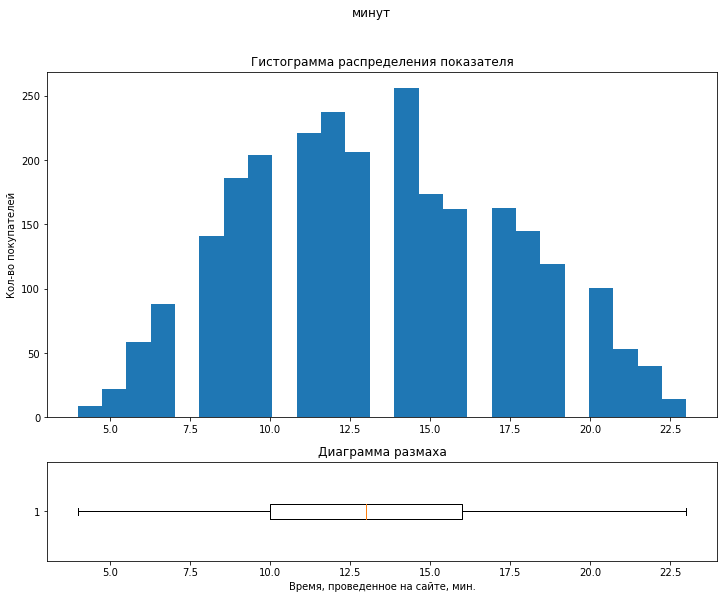

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


In [39]:
num_col_analysis(market_time, 'минут', 'Время, проведенное на сайте, мин.')

В целом ничего необычного. Распределение времени напоминает нормальное, без каких-либо выбросов. Минимальное время, которое клиенты проводили на сайте, составило 4 минуты, максимальное - 23 минуты. Однако осанованая масса клиентов проводит на сайте примерно от 6 до 20 минут.\
Удалим из таблицы тех же клиентов, что мы удалили в таблице с выручкой. И посмотрим на распределения времени на сайте по периодам (предыдущий/текущий).

In [40]:
# Создаем новую таблицу market_money_new без этих клиентов
market_time_new = market_time.query('id not in @clients_to_exclude')

# Проверяем число строк после исключения клиентов
print('Число строк после удаления клиентов с выбросами и низкой покупательской активностью',\
     market_time_new.shape[0])

Число строк после удаления клиентов с выбросами и низкой покупательской активностью 2592


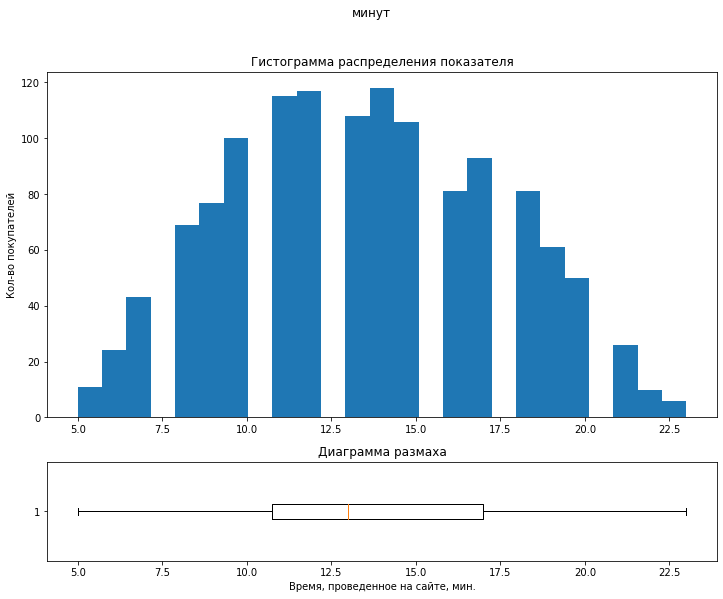

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
минут,1296.0,13.470679,3.93763,5.0,10.75,13.0,17.0,23.0


In [41]:
num_col_analysis(market_time_new.query('Период=="предыдущий_месяц"'), 'минут', 'Время, проведенное на сайте, мин.')

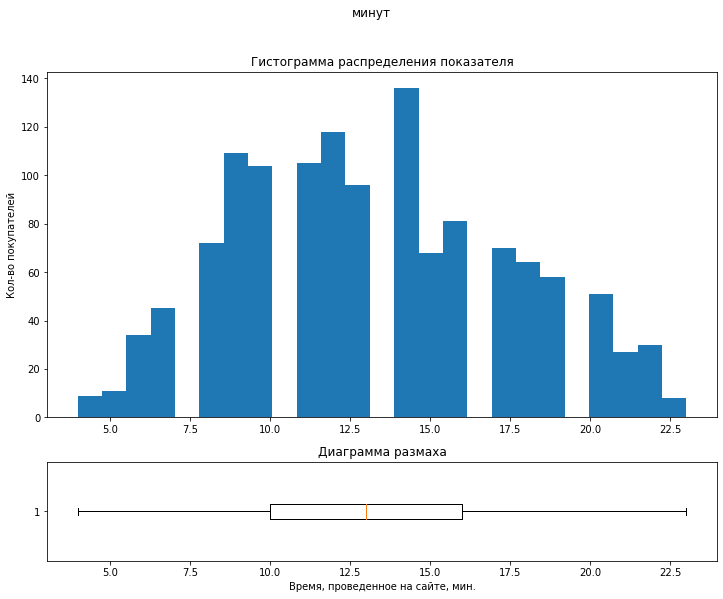

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
минут,1296.0,13.210648,4.221794,4.0,10.0,13.0,16.0,23.0


In [42]:
num_col_analysis(market_time_new.query('Период=="текущий_месяц"'), 'минут', 'Время, проведенное на сайте, мин.')

### Анализ таблицы money

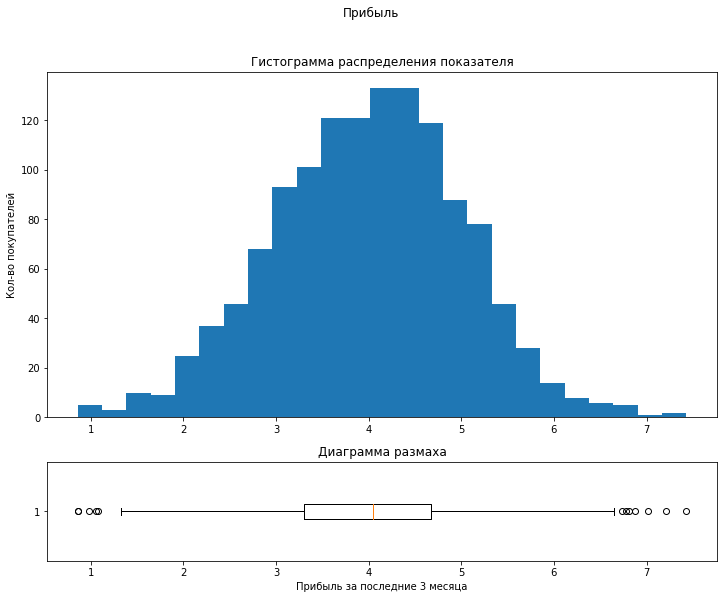

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Прибыль,1300.0,3.996631,1.013722,0.86,3.3,4.045,4.67,7.43


In [43]:
num_col_analysis(money, 'Прибыль', 'Прибыль за последние 3 месяца')

В целом распределение прибыли выглядит нормальным. Наблюдаются нетипичные для датасета значения за левыми и правыми усами. Однако если сравнивать распределение прибыли с распределением выручки, то можно заметить разную размерность прибыли и выручки. Есть предположение, что прибыль указана в тысячах. Иначе выглядит так, будто магазин работает еле перекрывая издержки. Для соответствия размерности между таблицами домножем столбец с прибылью на тысячу. Также удалим данные по клиентам к удалению.

In [44]:
# Создаем новую таблицу money_new без этих клиентов
money_new = money.query('id not in @clients_to_exclude')

# Проверяем число строк после исключения клиентов
print('Число строк после удаления клиентов с выбросами и низкой покупательской активностью',\
     money_new.shape[0])
money_new.head()

Число строк после удаления клиентов с выбросами и низкой покупательской активностью 1296


,id,Прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [45]:
# Домножим столбец с прибылью на 1000
money_new['Прибыль'] = money_new['Прибыль']*1000
money_new.head()

,id,Прибыль
1,215349,4160.0
2,215350,3130.0
3,215351,4870.0
4,215352,4210.0
5,215353,3950.0


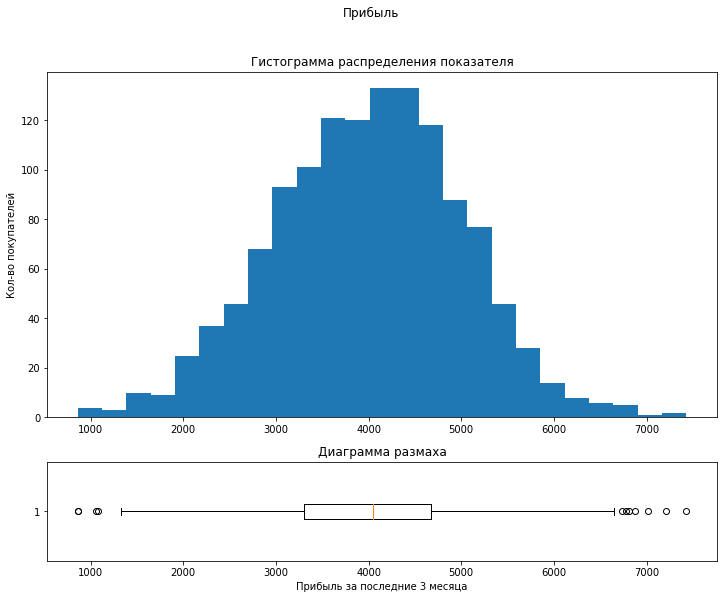

Описательная статистика показателя


,count,mean,std,min,25%,50%,75%,max
Прибыль,1296.0,3997.700617,1011.198207,860.0,3300.0,4045.0,4670.0,7430.0


In [46]:
num_col_analysis(money_new, 'Прибыль', 'Прибыль за последние 3 месяца')

Нам осталось удалить клиентов с покупательской активностью менее трех месяцев и выбросом по выручке из таблицы `market_file`. Сделаем это и сохраним результат в новой переменной `market_file_new`.

In [47]:
# Создаем новую таблицу market_file_new
market_file_new = market_file.query('id not in @clients_to_exclude')

# Проверяем число строк после исключения клиентов
print('Число строк после удаления клиентов с выбросами и низкой покупательской активностью',\
     market_file_new.shape[0])

Число строк после удаления клиентов с выбросами и низкой покупательской активностью 1296


## Объединение таблиц

Перед объединением данных таблиц `market_file_new`, `market_money_new` и `market_time_new` немного изменим конфигурацию таблиц `market_money_new` и `market_time_new`. В этих таблицах данные за разные периоды указаны в одном столбце. Нам необходимо для каждого периода сделать отдельный столбец. Сделаем это с помощью метода pivot_table().

In [48]:
# Делаем сводную таблицу и сохраняем ее в новой переменной
market_money_pivot = pd.pivot_table(market_money_new, values='Выручка', index='id', columns ='Период',
                                      aggfunc='sum')
# Задаем понятные названия столбцов
market_money_pivot.columns = ['Выручка_предыдущий_месяц','Выручка_препредыдущий_месяц','Выручка_текущий_месяц']

# Выведем первые 10 строк для проверки
market_money_pivot.head(10)

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
215354,5685.0,4503.0,5869.6
215355,3263.0,4749.0,3772.6
215356,4146.5,4433.0,4566.4
215358,3488.0,4727.0,4209.5


In [49]:
# Делаем сводную таблицу и сохраняем ее в новой переменной
market_time_pivot = pd.pivot_table(market_time_new, values='минут', index='id', columns ='Период',
                                      aggfunc='sum')

# Задаем понятные названия столбцов
market_time_pivot.columns = ['минут_предыдущий_месяц','минут_текущий_месяц']

# Выведем первые 10 строк для проверки
market_time_pivot.head(10)

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
215354,11,12
215355,12,10
215356,6,7
215358,14,10


Чтобы мы могли присоединить столбцы из полученных сводных таблиц к таблице `market_file_new`, установим в качестве индекса таблицы колонку c идентификатором клиента `id`.

In [50]:
market_file_new = market_file_new.set_index('id')
market_file_new.head(10)

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4


In [51]:
# Присоединяем сводные таблицы к market_file_new и сохраняем результат в переменной data_united
data_united = market_file_new.join([market_money_pivot, market_time_pivot],
                                   how='left')
data_united.head(10)

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


Проверим, что не возникло дублирования строк и в новых столбцах нет пропусков.

In [52]:
# Выведем кол-во строк после объединения
print('Количество строк после объединения:', data_united.shape[0])
# Проверим, есть ли неподтянувшиеся значения
data_united.isna().sum()

Количество строк после объединения: 1296


Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

## Корреляционный анализ

Так как у нас два класса целевого признака покупательской активности "Снизилась" и "Прежний уровень", построим матрицы корреляции каждого из классов от показателей.

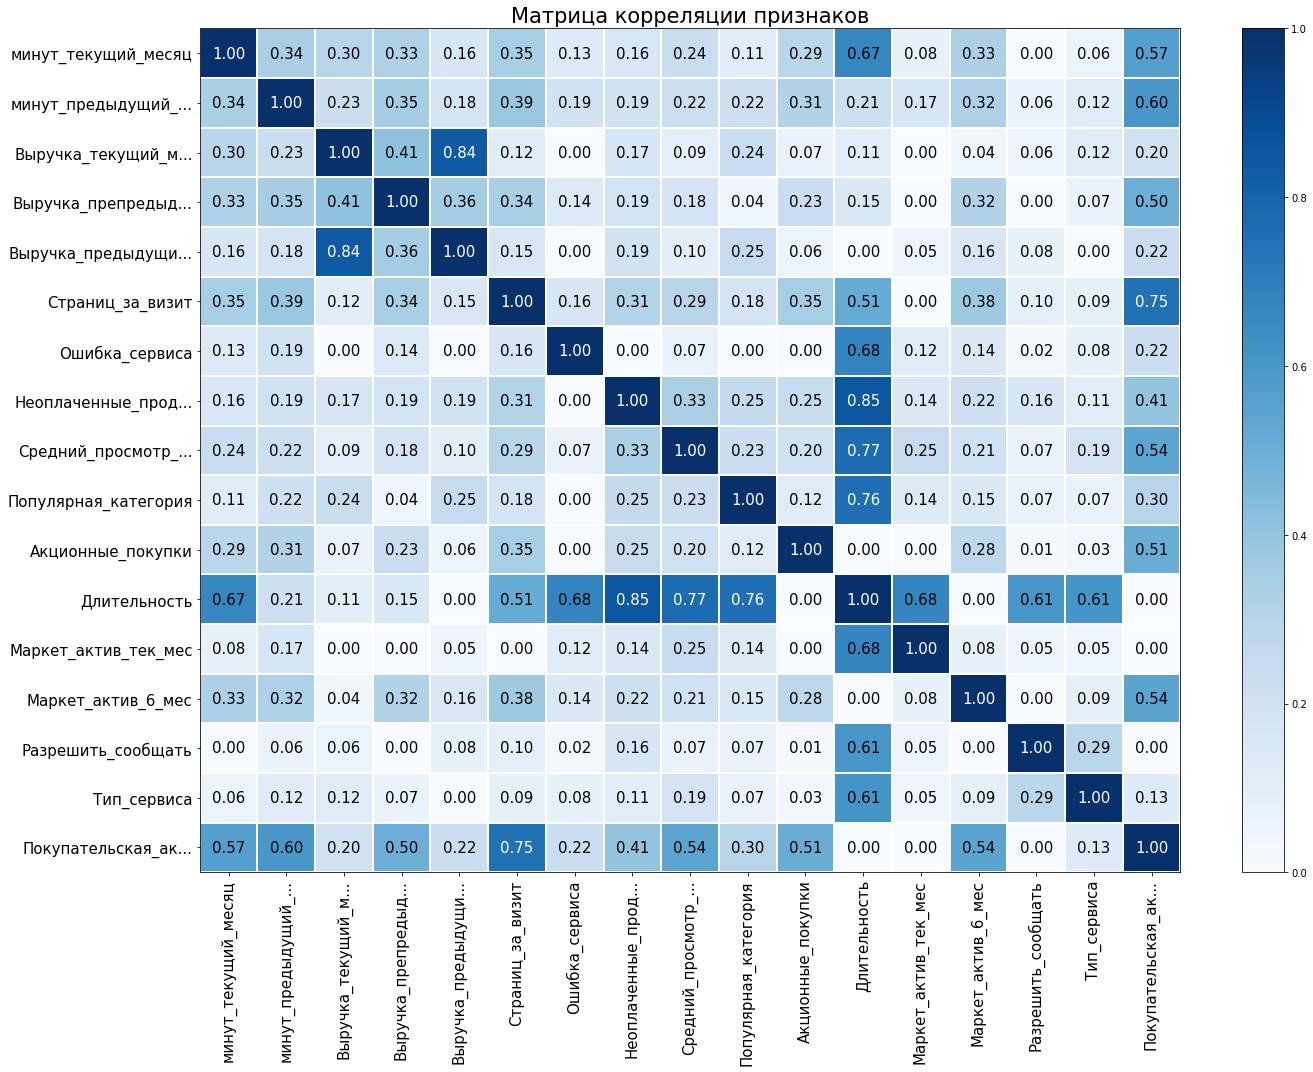

In [53]:
# Создадим список непрерывных переменных
interval_cols = ['Маркет_актив_6_мес', 'Акционные_покупки', 'Выручка_предыдущий_месяц', 
                 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

# Рассчитаем коэффициенты корреляции
phik_overview = phik_matrix(data_united, interval_cols=interval_cols)

# Выводим график корреляционной матрицы

plot_correlation_matrix(phik_overview.values,
                       x_labels=phik_overview.columns,
                       y_labels=phik_overview.index,
                       vmin=0, vmax=1, color_map='Blues',
                       title='Матрица корреляции признаков',
                       fontsize_factor=1.5,
                       figsize=(20,15))

Целевым признаком в нашем исследовании является покупательская активность. Согласно матрице корреляции наблюдается:
- высокая корреляция целевого признака со средним количествов страниц за визит (0.75);
- заметная корреляция целевого признака со значением времени, проведенного клиентом на сайте, за предыдущий (0.6) и текущий месяц (0.57);
- заметная корреляция целевого признака со средним количеством просмотренных категорий за визит (0.54);
- заметная корреляция целевого признака со среднемесячным значением количества маркентинговых коммуникаций (0,54). При это корреляции с количеством коммуникаций в текущем месяце нет;
- заметная корреляция целевого признака с долей акционных покупок (0.51);
- заметная корреляция целевого признака с выручкой за препредыдущий месяц (0.5), слабая - с выручкой за предыдущий месяц (0.22) и выручкой за текущий месяц (0.2);
- умеренная корреляция целевого признака с количеством неоплаченных продуктов (0.41) и популярной категорией товаров (0.3);
- слабая корреляция с количеством ошибок сервиса (0.22) и типом сервиса (0.13);
- отсутствие корреляции с длительностью с момента регистрации на сайте и разрешением клиента присылать дополнительные сведения о товаре. У признака `Разрешить сообщать` наблюдается очень слабая корреляция со всеми другими признаками, кроме длительности с момента регистрации на сайте. У длительности наоброт наблюдается достаточно высокая и заметная корреляция с другими признаками. Возможно она оказывает влияние на них. Исходя из вышесказанного, предлагается оставить признак длительности с момента регистрации и удали признак `Разрешить сообщать`.

Утечки информации из целевого признака не обнаружено.

Также мы можем заметить наличие высокой корреляции между следующими парами признаков:
- выручка текущего месяца и выручка предыдущего месяца - 0.83;
- длительность дней с момента регистрации на сайте и количество неоплаченных товаров в корзине за последние три месяца - 0.85.

Пока не будем с этим ничего делать, потому что эти признаки, кроме длительности с момента регистрации, могут быть важными при обучении модели. Однако будем иметь это ввиду.

## Использование пайплайнов

Перед тем как приступить к созданию пайплайна зададим необходимые для него переменные и разделим выборку на тренировочную и тестовую. Как мы обращали внимание выше, наблюдается дисбаланс классов целевого признака, поэтому при разделении данных на тренировочную и тестовую стратифицируем данные, передав целевой признак в настройку `stratify` функции `train_test_split()`.

In [54]:
# Зададим размер тестовой выборки и RANDOM_STATE
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделим данные на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(data_united.drop(['Покупательская_активность','Разрешить_сообщать'], axis=1),
                                                   data_united['Покупательская_активность'],
                                                   random_state=RANDOM_STATE,
                                                   test_size=TEST_SIZE,
                                                   stratify=data_united['Покупательская_активность'])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(972, 15) (972,)
(324, 15) (324,)


Перейдем к созданию пайплайна. Начнем с кодировки и масштабирования данных. К признакам `Тип_сервиса` и `Разрешить_сообщать` применим OneHotEncoder. Для признака `Популярная_категория` будем использовать OrdinalEncoder, чтобы не множить сущности. Этот признак носит номинальный характер, логичной последовательности значений у него нет.\
Для числовых признаков будем скейлер будем выбирать внутри пайплайна.

In [55]:
# Задидим списки признаков для кодировки и масштабирования данных
col_ohe = ['Тип_сервиса']
col_ord = ['Популярная_категория']
col_num = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий_месяц',
       'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц']

# Создаем пайплайн для подготовки признаков из списка col_ohe
ohe_pipe = Pipeline(
                   [('simple_imputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore'
                                          #, sparse_output='False'
                                         ))
                   ])
# Создаем пайплайн для подготовки признаков из списка col_ord
ord_pipe = Pipeline(
                   [('simple_imputer_bf_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ord', OrdinalEncoder(
                                           categories = [['Мелкая бытовая техника и электроника',
                                                         'Техника для красоты и здоровья', 'Кухонная посуда',
                                                         'Товары для детей', 'Домашний текстиль', 
                                                         'Косметика и аксесуары']],
                                           handle_unknown='use_encoded_value', unknown_value=np.nan)),
                    ('simple_imputer_aft_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                   ])

# Создаем общий паплайн подготовки признаков
data_preprocessor = ColumnTransformer([
                                        ('ohe', ohe_pipe, col_ohe),
                                        ('ord', ord_pipe, col_ord),
                                        ('num', MinMaxScaler(), col_num),
                                       ],
                                     remainder = 'passthrough')

Зададим список словарей для подбора гиперпараметров моделей. Мы будем подбирать следующие гиперпараметры для моделей:
- DecisionTreeClassifier: подберем максимальную глубину дерева из диапазона `max_depth` от 2 до 5 включительно и минимальное количество объектов в узле для разделения `min_samples_split` из диапазона от 2 до 5 включительно;
- KNeighnorsClassifier(): подберем число ближайших соседей `n_neighbors` из диапазиона от 2 до 10 включительно;
- SVC(): подберем параметр регуляризации `gamma` из диапазона от 1 до 5 включительно.
- LogisticRegression(): подберем параметр регуляризации `С` из диапазона от 1 до 5 включительно.

Перед нами стоит задача создать модель, которая может предсказать снизится покупательская активность либо останется прежней. Для интернет-магазина, с одной стороны, c точки зрения прибыли было бы полезнее минимизировать число тех покупаталей, чья покупательская способность была определена как прежняя, но она самом деле снизилась (в нашем случает это ошибки FN). C другой стороны, если мы не будем обращать внимания на ошибки FP (активность определена как снизившаяся, а по факту прежняя), то рискуем завалить клиента, у которого снижения активности не происходило, маркетинговыми коммуникациями, что действует им на нервы и также не очень хорошо влияет на бизнес. Поэтому для оценки качества модели возьмем более универсальную метрику ROC-AUC.

In [56]:
# Создадим итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Создадим словарь для подбора гиперпараметров
param_grid = [
    # Словарь для модели дерева решений
 {
    'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': range(2,6),
    'models__min_samples_split': range(2,6),
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
 },
    #Словарь для k ближайших соседей
 {
     'models':[KNeighborsClassifier()],
     'models__n_neighbors':range(2,11),
     'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
 },
    
    #Словарь для модели опорных векторов
    {'models':[SVC(random_state=RANDOM_STATE, probability=True)],
    'models__gamma':range(1,6),
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    #Словарь для модели логистической регрессии
  {
    'models':[LogisticRegression(random_state=RANDOM_STATE)],
    'models__C':range(1,6),
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
  }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print(randomized_search.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Тип_сервиса']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_bf_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                    

В результате подбора моделей и гиперпараметров лучшей моделью оказалась модель логистической регрессии cо значением параметра регуляризации, равным 2 и наилучшим скейлером количественных столбцов MinMaxScaler().\
Мы видим, что у этой модели на тренировочных данных получилось очень хорошее значение метрики ROC_AUC=0.89. Оценим значение метрики на тестовой выборке.

In [57]:
y_test_preds = randomized_search.predict(X_test)
y_test_probas = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_probas[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.918173360838086


 На тестовой выборке значение метрики ROC-AUC вышло еще больше - 0.91. 

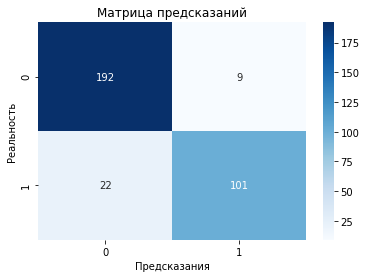

In [58]:
cm = confusion_matrix(y_test, y_test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица предсказаний')
plt.ylabel('Реальность')
plt.xlabel('Предсказания');

В 101 случае класс покупательской активности был правильно определен как снизившийся(True Positive), в 192 случаях модель правильно определила прежний уровень активности как прежний (True Negative). Ошибка первого рода (FP) в 9 предсказаниях. Ошибка второго рода (FN) в 22 предсказаниях.

## Анализ важности признаков

Посмотрим важность признаков лучшей модели с помощью метода SHAP. Построим график общей значимости признаков и график влияния признаков на предсказания модели.

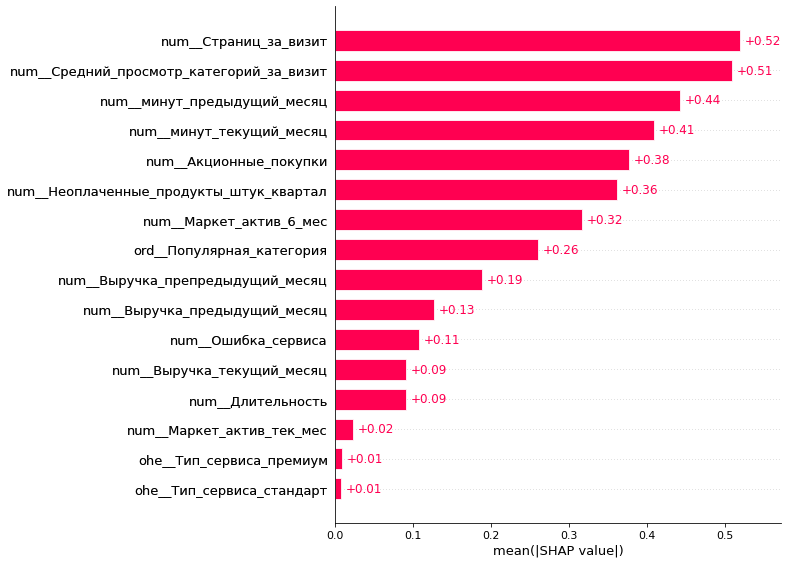

In [59]:
X_train_imp = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_imp)

X_test_imp = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_imp = pd.DataFrame(X_test_imp, columns =feature_names)
shap_values = explainer(X_test_imp)

shap.plots.bar(shap_values, max_display=17)

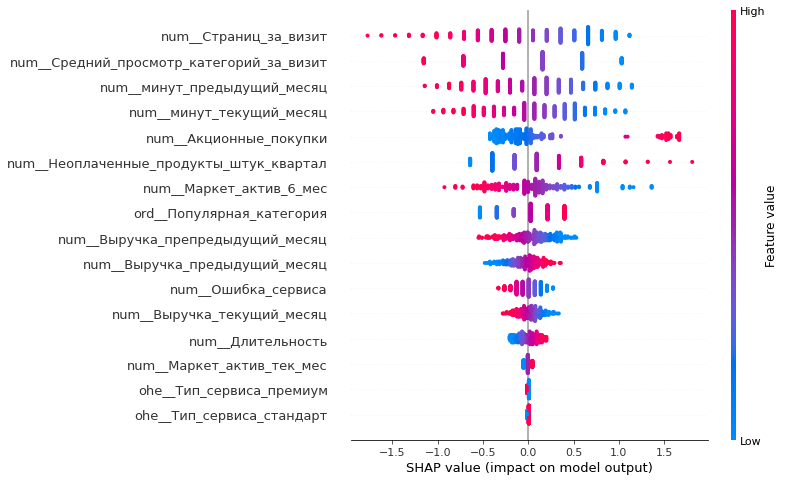

In [60]:
shap.plots.beeswarm(shap_values, max_display=17) 

Мы видим, что как и по результатом матрицы корреляции, наиболее важным признаком для определения класса является признак 'Страниц_за_визит'. Вторым по важности в отличичие от матрицы корреляции является среднее число просмотренных категорий за визит (по матрице корреляции вторым по важности было значение времени на сайте за предыдущий месяц). Третьими и четвертыми являются время, проведенное на сайте за предыдущий и текущий месяцы, пятым и шестым - доля акционных покупок и количество неоплаченных товаров в корзие за последний квартал. Также важными являются среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев и популярная категория товара у клиента. На наш взгляд это наиболее значимые признаки для нашей модели.

Наименее важными признаками является тип сервиса. В предсказании типа класса покупательской активности он оказался бесполезным. Покупательская активность видимо может снизиться вне зависимости от типа сервиса. Также очень малый вклад в предсказание класса оказало число маркетинговых коммуникаций за текущий месяц. Здесь возникает вопрос, почему это так. Связано ли это с тем, что покупателю нужно "созреть" и подумать, чтобы приобрести товар, который продвигается маркетинговыми методами?\

Сказанное выше, можно учесть при моделировании, например, удалить из рассмотрения наименее значимые признаки либо признаки, значимость которых ниже определенного порога, например, 0.13. Это позволит упростить модель, что возможно приведет к росту ее качества: модель не будет пытаться объяснить влияние незначимых факторов и лучше уловить зависимости между значимыми факторами и таргетом.

Результаты наблюдаемого на графике выше и его интерпретацию интернет-магазин может использовать для принятия бизнес-решений. Например, зная, что высокое значение признака 'Страниц_за_визит' снижает вероятность отнесения клиента к классу 1 (1=покупательская активность снизилась), интернет-магазин может улучшить дизайн сайта с помощью UX/UI и спровоцировать клиента взаимодействовать с большим количеством страниц на сайте. То же самое с категориями: можно предлагать клиенту рекомендации каких-то товаров из другой категории, например, каких-то сопутствующих товаров (батарейки к технике, косметика для ухода за малышами при покупке товаров для детей и т.п.).

## Сегментация покупателей

Для начала создадим таблицу для сегментации клиентов. Для этого сделаем таблицу на основе тестовых данных, к которым присоединим данные о прибыльности клиента и предсказание вероятности снижения покупательской активности к тому или иному классу.

In [61]:
# Создадим таблицу для сегментации
segmentation = X_test.join(money_new.set_index('id'), how='left')
segmentation['Вероятность_снижения_активности'] = y_test_probas[:,1]
# Проверка качества объединения таблиц
print('Число строк после объединения таблиц:', segmentation.shape[0])
segmentation.isna().sum()

Число строк после объединения таблиц: 324


Тип_сервиса                            0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
Прибыль                                0
Вероятность_снижения_активности        0
dtype: int64

In [62]:
segmentation.head()

,Тип_сервиса,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль,Вероятность_снижения_активности
id,,,,,,,,,,,,,,,,,
216161,стандарт,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,4690.0,0.013763
215654,премиум,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,2750.0,0.985771
216307,премиум,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,3160.0,0.110754
215501,премиум,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,3740.0,0.770649
215934,стандарт,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,4400.0,0.572743


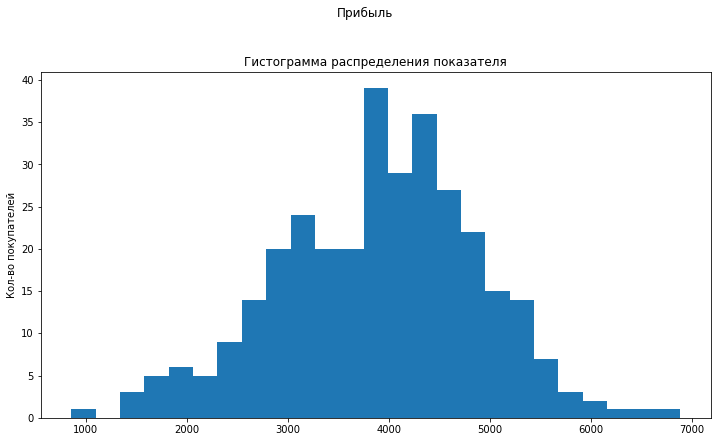

In [63]:
num_col_analysis(segmentation, 'Прибыль', 'Прибыль за последние 3 месяца',boxplot=False, stats=False)

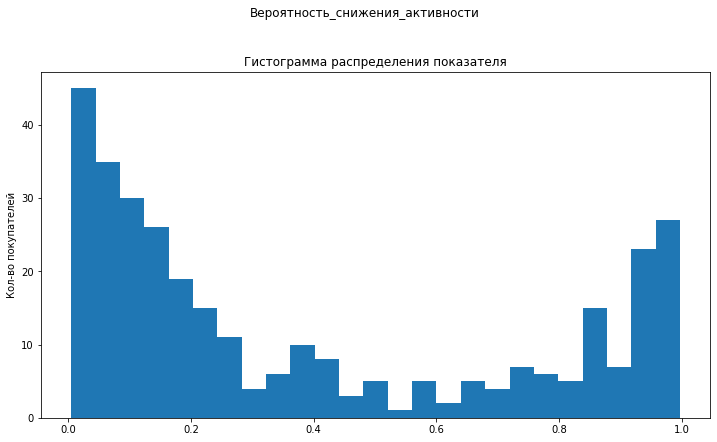

In [64]:
num_col_analysis(segmentation, 'Вероятность_снижения_активности', 
                 'Вероятность снижения покупательской активности', boxplot=False, stats=False)

Исходя из графика распределения прибыли,генерируемой клиентами, мы можем условно выделить три сегмента:
- клиенты с низкой прибылью (менее 2500),
- средней прибылью (от 2500 до 5500),
- с высокой прибылью (свыше 5500).
По вероятности снижения покупательской активности клиентов предлагается выделить два сегмента:
- высокая  - вероятность снижения >0.7;
- вероятность снижения<0.7.

In [65]:
# Зададим функцию для определения сегмента клиента по прибыли
def money_segment(revenue):
    if revenue<2500:
        return 'низкая'
    elif revenue>=2500 and revenue<5500:
        return 'средняя'
    else: 
        return 'высокая'
    
segmentation['Уровень_прибыли'] = segmentation['Прибыль'].apply(money_segment)

In [66]:
#Зададим функцию определения категории риска снижения покупательской активности
def activity_prob(probability):
    if probability>=0.7:
        return 'выше_0.7'
    else:
        return 'ниже_0.7'

segmentation['Вероятность_снижения_категория'] = segmentation['Вероятность_снижения_активности'].apply(activity_prob)

segmentation.head()

,Тип_сервиса,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль,Вероятность_снижения_активности,Уровень_прибыли,Вероятность_снижения_категория
id,,,,,,,,,,,,,,,,,,,
216161,стандарт,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,4690.0,0.013763,средняя,ниже_0.7
215654,премиум,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,2750.0,0.985771,средняя,выше_0.7
216307,премиум,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,3160.0,0.110754,средняя,ниже_0.7
215501,премиум,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,3740.0,0.770649,средняя,выше_0.7
215934,стандарт,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,4400.0,0.572743,средняя,ниже_0.7


Для того, чтобы проще было сегментировать клиентов сделаем визиуализацию показателей таблицы для сегментации.

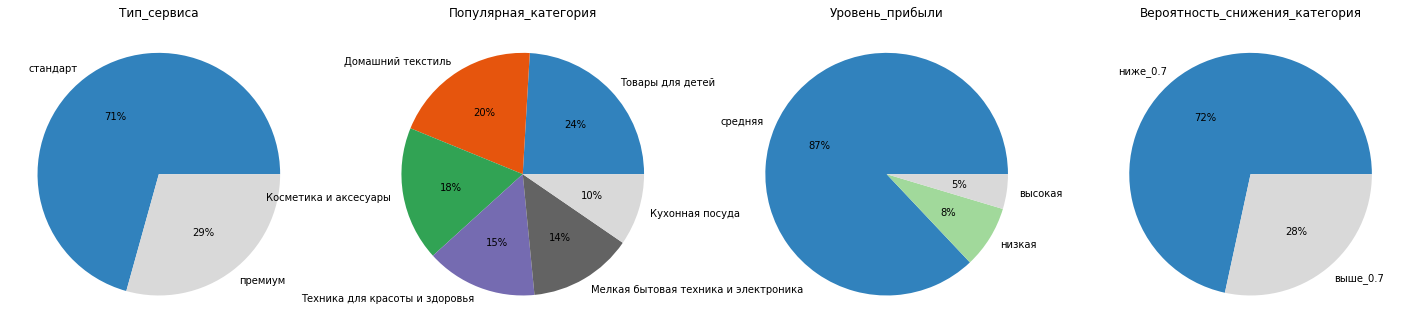

In [67]:
# Задаем список столбцов и выводим графики
segmentaion_cat = segmentation.select_dtypes(include='object').columns   
pie_plot(segmentation, segmentaion_cat)

In [68]:
segmentation.pivot_table(index='Уровень_прибыли',values='Прибыль',aggfunc='sum')

,Прибыль
Уровень_прибыли,
высокая,87870.0
низкая,52920.0
средняя,1125220.0


Согласно нашей задаче - удержание активности постоянных клиентов за счет персонализированных предложений - помимо предсказания вероятности снижения покупательной активности, нам необходимо разработать рекомендации для интернет-магазина в части увеличения покупательской активности одной из групп клиентов. Проведем анализ клиентов для выбора такой группы.

**Уровень прибыли**\
Большая часть клиентов интернет-магазина генерирует средний уровень прибыли. Мы видели это как на графике распределения прибыли, так и видим это на круговой диаграмме. Именно этот сегмент клиентов генерирует основную прибыль интернет магазина и на удержание активности этого сегмента стоит делать основной акцент.

**Вероятность снижения покупательской активности**\
Помимо уровня прибыли очевидно нужно учитывать предсказание уровня покупательской активности. Посмотрим, у какого количества клиентов, генерируюших средний уровень прибыли, высокая вероятность снижения активности.

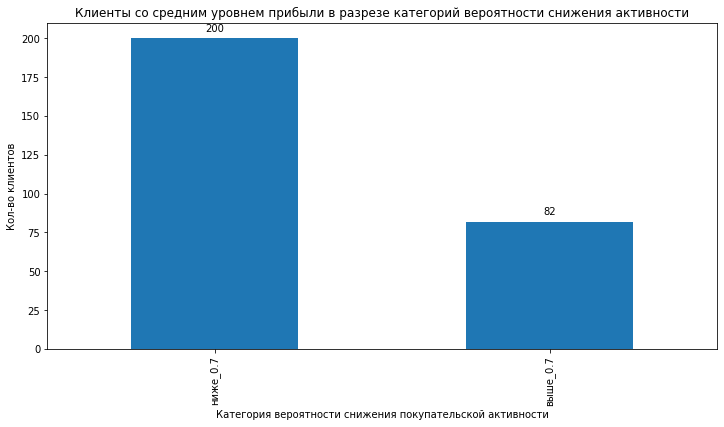

In [69]:
ax = (segmentation.query('Уровень_прибыли=="средняя"')['Вероятность_снижения_категория']
      .value_counts().plot(kind = 'bar',
                           title='Клиенты со средним уровнем прибыли в разрезе категорий вероятности снижения активности',
                           xlabel='Категория вероятности снижения покупательской активности', 
                           ylabel='Кол-во клиентов',
                           figsize=(12,6))
         

)                                                                              
# Добавим подписи с числом клиентов к соответствующей категории
# Для этого зададим функцию add_value_labels
def add_value_labels(ax, spacing=15):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'top'
        label = "{:}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va) 
    
add_value_labels(ax)

Таким образом у нас есть 82 клиента со средним уровнем прибыли и высокой вероятностью снижения покупательской активности. Попробуем выработать рекомендации по поддержанию их высокой покупательской активности.

Для этого проанализируем признаки, которые оказывают наибольшее влияние на уровень покупательской активности, согласно нашей модели, и наиболее отражают покупательское поведение.

Проанализируем, какие категории товаров являются наиболее популярными у выбранной категории клиентов.

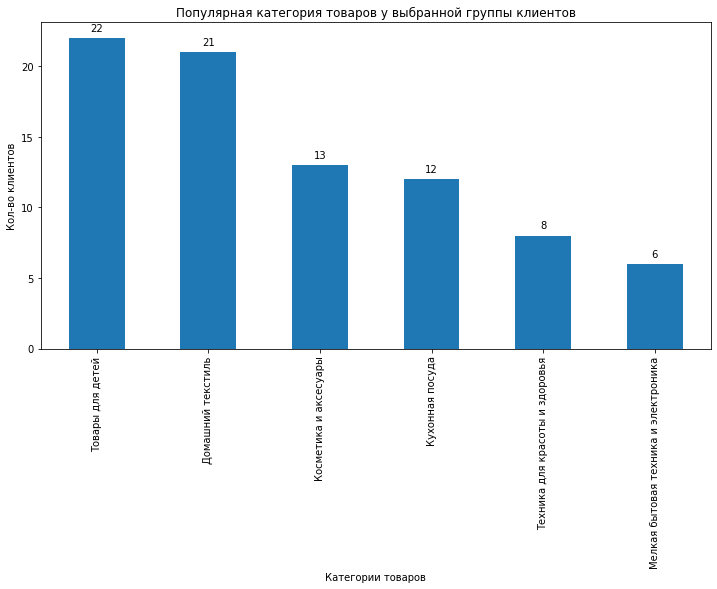

In [70]:
# Выбранная группа
group = segmentation.query('Уровень_прибыли=="средняя"& Вероятность_снижения_категория=="выше_0.7"')

ax = (group['Популярная_категория'].value_counts().plot(
                           kind = 'bar',
                           title='Популярная категория товаров у выбранной группы клиентов',
                           xlabel='Категории товаров', 
                           ylabel='Кол-во клиентов',
                           figsize=(12,6))
     )

add_value_labels(ax)

Мы получили наиболее популярные категории для выбранной группы клиентов. Практически у половины клиентов из выбранной категории самыми популярными категориями товаров являются товары для детей (22 клиента) и домашний текситель(21 клиент). 13 клиентов любят покупать косметику и аксессуары, 12 - кухонную посуду, 8 - технику для красоты и здоровья, 6 - мелкую бытовую технику и электронику.

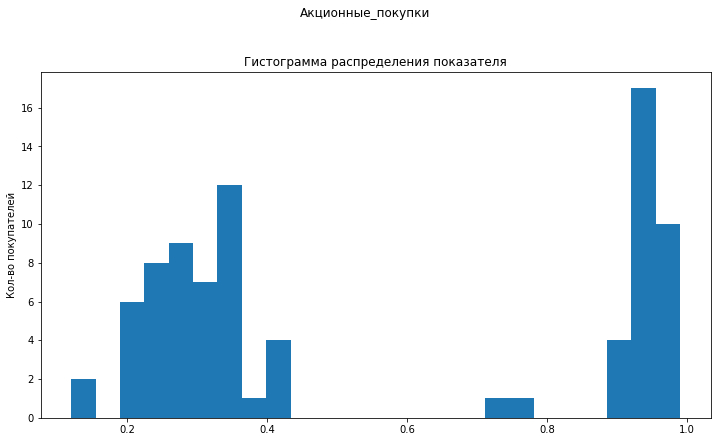

In [71]:
num_col_analysis(group, 'Акционные_покупки', 'Доля покупок по акции за последние 6 месяцев у выбранной группы клиентов',
                 boxplot=False, stats=False)

In [72]:
print('Количество покупателей с низкой долей акционных покупок:', group.query('Акционные_покупки<0.5').shape[0])
print('Количество покупателей с большой долей акционных покупок:', group.query('Акционные_покупки>=0.5').shape[0])

Количество покупателей с низкой долей акционных покупок: 49
Количество покупателей с большой долей акционных покупок: 33


Выбранная группа покупателей любит покупать товары по акции, но в разной степени. 49 клиентов по акции покупают менее 50% товаров, 33 клиента стараются покупать товары преимущественно по акциям.

В целом мы видим, что практически все клиенты из выбранной группы, приобретают хотя бы часть товаров по акции. Соответственно, интернет магазину можно порекомендовать направлять клиентам персонализованные предложения с промокодами на покупки ко дню рождения или другим праздникам либо списки товаров по акции из той категории, которая является у них популярной. Также можно, как уже отмечалось выше, предлагать клиентам те товары, которые являются сопутствующими тем, что они приобрели в прошлом или положили в корзину при текущей визите.

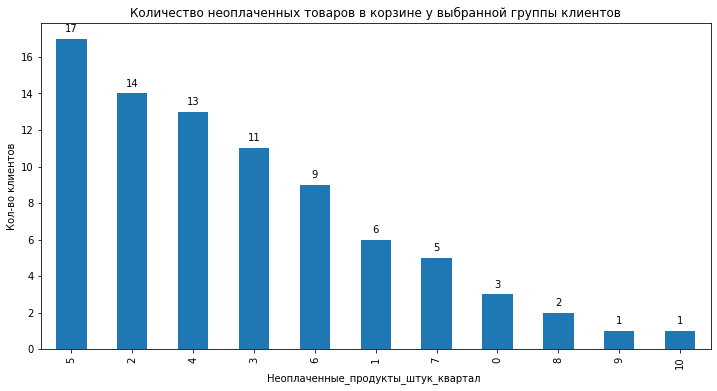

In [73]:
ax = (group['Неоплаченные_продукты_штук_квартал'].value_counts().plot(
                           kind = 'bar',
                           title='Количество неоплаченных товаров в корзине у выбранной группы клиентов',
                           xlabel='Неоплаченные_продукты_штук_квартал ', 
                           ylabel='Кол-во клиентов',
                           figsize=(12,6))
     )

add_value_labels(ax)

У выбранной нами группы клиентов, как оказалось, достаточно большое количество товаров остаются в корзине неоплаченными: по 5 товаров в квартал неоплачивают 17 клиентов, 14 клиентов не оплачивают по 2 товара, 13 клиентов - по 4 товара, 11 клиентов - по 3 товара и 9 клиентов - по 6 товаров. Это достаточно большое количество неоплат. Высокий уровень неоплаченных товаров мы отмечали и на полной выборке. Интернет магазину следует разобраться, в чем причина такого большого количества неоплат. Связано ли это, например, c неудобным и долгим процесс оплаты товара из корзины, возникающими ошибками при оплате на стороне банка, падаением сайта при переходе к оплате или какими-то иными причинами.

Для дополнительного анализа было бы полезно рассмотреть не только тех клиентов со средним уровнем прибыли, у который высокая вероятность снижения покупательской активности, но и тех,  у кого она на низком и среднем уровне. Такой анализ позволит интернет-магазину лучше понимать своих клиентов-основных генераторов прибыли и выстраивать с ними более качественную коммуникацию еще до того момента, когда модель прдскажет, что их покупательская активность может снизиться.

## Общий вывод

**Задача**


Перед нами была поставлена задача разработки решения c применением машинного обучения, которое позволит персонализировать предложения постоянным клиентам интернет-магазина, чтобы увеличить их покупательскую активность. 

Покупательскую активность клиентов магазина принято измерять в категориях "Снизилась" и "Прежний уровень". Предсказание вероятности отнесения клиента к той или иной категории в переводе на язык машинного обучения представляет собой задачу классификации.

**Исходные данные и предобработка**

Исходные данные были представлены таблицами:
- `market_file` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- `market_time` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- `market_money`- данные о выручке, которую получает магазин с покупателя;
- `money` - данные о среднемесячной прибыли покупателя за последние 3 месяца.

В ходе проекта были выполнены следующие этапы предобработки данных:
- выполнена проверка соответствия типов данных столбцов их смысловому содержанию. Несоответствия типов данных не было выявлено; 
- выполнена проверка на наличие строк-полных дубликатов во всех таблицах. Подобных строк не обнаружено;
- выполнена проверка на наличие неявных дубликатов категориальных признаках. Были выявлены и устранены двойной вариант написания типа сервиса 'стандарт' в таблице `market_file`, различный вариант написания категории периода 'предыдущий_месяц' между разными таблицами.

Также был проведен исследовательский анализ данных, направленный на изучение основных характеристик всех признаков и выявление нетипичных значений. По результатам исследовательского анализа данных были: 
- исключены из рассмотрения данные по клиенту с нетипично высоким уровнем выручки для клиентов данного интернет магазина. Магазину рекомендуется обратить внимание на данного клиента (id 215380) с тем, чтобы понять действительно ли по данному клиенту в текущем месяце получилась така высокая выручка или это ошибка;
- исключены клиенты с покупательской активностью менее 3 месяцев.


 **Поиск лучшей модели**
 
 Для подбора лучшей модели классификации был настроен пайплайн, который с помощью автоматизированного подбора гиперпараметров с помощью класса `GridSearchCV`, осуществлял выбор наилучшей из набора моделей на основе результатов метрики ROC_AUC. Перед подбором моделей внутри пайплайна также осуществлялось кодирование и масштабирование данных. Для кодирования категориальных данных были использованы OneHotEncoder и OrdinalEncoder, масштабирование данных осуществлялось с помощью скейлеров StandardScaler и MinMaxScaler. Выбор одного из этих скейлеров осуществлялся внутри пайплайна.
 
Набор моделей и гиперпараметров включал следующие:
- `DecisionTreeClassifier()`: 
   - максимальная глубина дерева (max_depth) из диапазона от 2 до 5 включительно;
   - минимальное количество объектов в узле для разделения (min_samples_split) из диапазона от 2 до 5 включительно;
- `KNeighnorsClassifier()`:
   - число ближайших соседей n_neighbors из диапазиона от 2 до 10 включительно;
- `SVC()`: 
   - параметр регуляризации gamma из диапазона от 1 до 5 включительно;
- `LogisticRegression()`: 
   - параметр регуляризации С из диапазона от 1 до 5 включительно.
   
Лучшей моделью стала модель логистической регрессии cо значением параметра регуляризации, равным 2 и наилучшим скейлером количественных столбцов MinMaxScaler(). Значение метрики ROC_AUC данной модели на тренировочных данных составило 0.89. 

**Рекомендации**

На базе выбранной модели были выявлены важные признаки для уровня покупательской активности. Например, наиболее значимыми являются число просмотренных страниц за визит,  среднее число просмотренных категорий за визит, время, проведенное на сайте за предыдущий и текущий месяцы, доля акционных покупок и количество неоплаченных товаров в корзине за последний квартал). Интернет-магазину стоит понимать, какие значимые признаки влияют на покупательскую активность, и уметь воздействовать на нее через них.

С помощью выбранной модели были предсказаны вероятности снижения покупательской активности для всех клиентов тестовой выборки. 

На основе прибыли, генерируемой клиентами, и вероятности снижения покупательской активности были выделены следующие сегменты клиентов:
- по уровню прибыли:
   - низкая;
   - средняя;
   - высокая;
- по вероятности снижения покупательской активности:
   - выше 0.7;
   - ниже 0.7.
   
Так как основным сегментом, генерирующим прибыль, является сегмент клиентов со средней прибылью, для решения задачи была выбрана группа клиентов со средней прибылью и вероятностью снижения покупательской активности выше 0.7. Для выбранной группы были подготовлены следующие рекомендации для поддержания/повышения их активности:
- направлять клиентам персонализованные предложения с промокодами на покупки ко дню рождения или другим праздникам либо списки товаров по акции из той категории, которая является у них популярной;
- предлагать клиентам те товары, которые являются сопутствующими тем, что они приобрели в прошлом или положили в корзину при текущей визите;
- ввиду достаточно большого количество неоплаченных товаров в корзине у большей части покупателей рекомендуется разобраться с причинами большого количества неоплат.

Для дополнительного анализа было бы полезно рассмотреть не только тех клиентов со средним уровнем прибыли, у который высокая вероятность снижения покупательской активности, но и тех,  у кого она на низком и среднем уровне. Такой анализ позволит интернет-магазину лучше понимать своих клиентов-основных генераторов прибыли и выстраивать с ними более качественную коммуникацию еще до того момента, когда модель прдскажет, что их покупательская активность может снизиться.